In [1]:
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv , os , pickle , cv2 , tqdm , time
from ARHMM_wo_test import find_best_K
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
import ruptures as rpt
from overlay_states import overlay_states
from ARHMM_utils import preprocess_data
from ARHMM_plots import make_cross_likelihood_matrix
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [12]:
start_K = 1
stop_K = 50

div=10
smooth=True
box_size=0.6
box_pixel=400
T=2e-3
d=5
seed=1337

data_frame_2050 = pd.read_csv("C:/Users/magnu/OneDrive/Dokument/KI/KI2020/New_data_201120/Mouse_2050/20201120_behaviour2020_v_2050_for_frans_1_pose_data.csv")
#data_frame2 = pd.read_csv("new_data_no_cord/20201120_behaviour2020_v_frans_1_pose_data.csv")#[14500:23000]
data_frame_2053 = pd.read_csv("C:/Users/magnu/OneDrive/Dokument/KI/KI2020/New_data_201120/Mouse_2053/20201120_behaviour2020_v_2053_for_frans_1_pose_data.csv")
#data_frame2 = pd.read_csv("mouse/20201202_behaviour2020_v_6287_distractionduring_task_vol2_1_pose_data.csv")#[10000:230000]
#data_frame3 = pd.read.csv("")
#data = data_frame_2050.to_numpy()
#print(data.shape)
test_mouse_interval_start = 1000
test_mouse_interval_end = 220000

test_mouse_interval = range(test_mouse_interval_start,test_mouse_interval_end)

# Preprocess data
test_mouse_data_to_use , df1 , speed , head_body_angle , body_len , outliers = preprocess_data(data_frame_2053, test_mouse_interval, div, smooth, box_size, box_pixel, d, T)


train_mouse_interval_start = 0
train_mouse_interval_end = 220000
train_mouse_interval = range(train_mouse_interval_start,train_mouse_interval_end)
train_mouse_data_to_use , df2 , speed , head_body_angle , body_len , outliers = preprocess_data(data_frame_2050, train_mouse_interval, div, smooth, box_size, box_pixel, d, T)

C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\magnu\OneDrive\Dokument\KI\KI2020\Analysis\ARHMM_utils.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of outliers removed: 473 (0.021598173515981735 %)
Number of outliers removed: 285 (0.012954545454545455 %)


In [7]:
#train_data, val_data, = train_test_split(train_mouse_data_to_use, test_size=0.3,shuffle=False)
#test_data, val_data = train_test_split(test_data, test_size=0.5)
#print(train_data.shape)
#best_train_lls, best_val_lls, best_test_ll, test_lls,train_lls,hmm, best_K =find_best_K(train_data, test_data, val_data,start_K,stop_K,2)
#all_train_lls , all_val_lls , best_hmm_AIC , best_K_AIC , best_hmm , best_K , AIC,hmm_s =find_best_K(train_data, val_data,start_K,stop_K,kappa=1,seed=1337,early_stopping=True,epochs=50,return_all=True)
#print("best train ll",best_train_lls)
#print("best val ll",best_val_lls)
#print("best test ll",best_test_ll)

hmm = pickle.load(open("C:/Users/magnu/OneDrive/Dokument/KI/KI2020/New_data_201120/Mouse_2050/hmm_model_11_states_2500_kappa.p", "rb" ))

#hmm_z = hmm.most_likely_states(data_to_use,)
#print("best_K",best_K)
#print("best_K_AIC",best_K_AIC)

In [8]:
plt.figure(1)
plt.plot(np.arange(1,len(np.amax(all_val_lls,axis=1))+1),np.amax(all_val_lls,axis=1))
plt.xlabel("States K")
plt.ylabel("Val log likelihood")
plt.savefig("val_ll_mouse_distracted.png")

NameError: name 'all_val_lls' is not defined

<Figure size 432x288 with 0 Axes>

In [9]:
test_LLs = np.zeros(len(hmm_s))
for i,hmm in enumerate(hmm_s):
    test_LLs[i] = hmm.log_probability(test_mouse_data_to_use)/test_mouse_data_to_use.shape[0]
plt.plot(test_LLs)

NameError: name 'hmm_s' is not defined

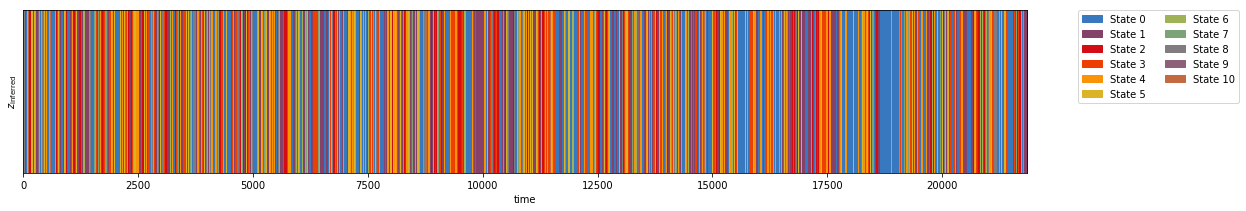

In [10]:
#hmm = best_hmm
time_bins = test_mouse_data_to_use.shape[1]
hmm_z = hmm.most_likely_states(test_mouse_data_to_use,)
num_states= 25
import matplotlib.patches as mpatches
values = np.unique(hmm_z)
plt.figure(2,figsize=(18, 3))
im = plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=max(hmm_z) + 1,interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in values]

patches = [ mpatches.Patch(color=colors[i], label="State {l}".format(l=values[i]) ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=(len(values) // 11) + 1)
#plt.xlim(0,10)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.savefig("colored_states.png")

          speed       yaw        bl
0      0.050749  0.379629  0.055023
1      0.020407  0.319332  0.055042
2      0.009492  0.294464  0.054935
3      0.027801  0.227816  0.056489
4      0.022339  0.194468  0.057386
...         ...       ...       ...
21848  0.017193 -0.033060  0.058969
21849  0.015956 -0.030381  0.059250
21850  0.012358 -0.035223  0.059562
21851  0.004596 -0.026774  0.059266
21852  0.014391 -0.026935  0.059394

[21853 rows x 3 columns]


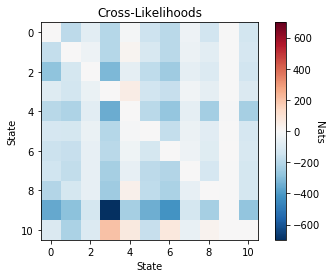

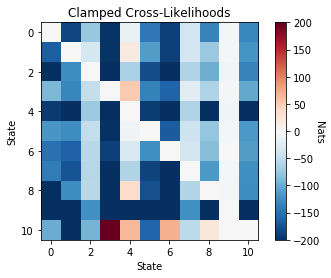

In [20]:
df = pd.DataFrame(test_mouse_data_to_use,columns=['speed','yaw','bl'])
print(df)
df['state'] = hmm_z
#df1['state'] = hmm_z
#df2['state'] = hmm_z
#print(df['state'][0:60])
make_cross_likelihood_matrix(hmm,df,"cll.png")

In [17]:
df2

,frame,ba_len,g_vec_x,g_vec_y,cog_x,cog_y,b_vec_x,b_vec_y,head_angle,body_angle,head_body_angle,speed,yaw,bl
8,16.0,32.277697,10.315544,-13.979249,149.719173,30.913118,26.291557,-18.724415,-0.935072,-0.618856,-0.316216,0.342327,-0.314660,0.048558
18,36.0,33.891436,11.195244,-14.502372,150.135052,30.044955,27.250755,-20.150081,-0.913389,-0.636703,-0.276685,0.033886,-0.276323,0.050804
28,56.0,32.473013,11.647865,-14.269793,149.755024,30.128304,25.443977,-20.176734,-0.886219,-0.670450,-0.215769,0.030523,-0.215942,0.048708
38,76.0,31.128733,12.135475,-13.866791,149.563381,30.307396,23.892815,-19.953231,-0.851883,-0.695788,-0.156095,0.028514,-0.156399,0.046699
48,96.0,30.457980,12.065605,-13.626044,149.463650,30.421254,23.151878,-19.790884,-0.846061,-0.707291,-0.138770,0.010257,-0.138416,0.045684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219959,472468.0,37.695261,1.264397,14.220055,222.126499,122.017975,-2.986137,37.576797,1.482113,1.650097,-0.167984,0.119347,-0.168197,0.056553
219969,472488.0,36.734122,0.787788,14.376808,222.397465,123.418522,-2.977043,36.613289,1.516055,1.651928,-0.135873,0.099973,-0.135851,0.055094
219979,472508.0,36.676127,0.116173,14.546814,223.176365,124.382492,-3.434593,36.514954,1.562810,1.664580,-0.101770,0.101205,-0.101604,0.055021
219989,472528.0,37.343342,-0.141396,14.647720,224.226261,125.519577,-4.630241,37.055176,1.580449,1.695107,-0.114658,0.114288,-0.114479,0.055998
